# Non-linear Dimensionality Reduction on BERT Embeddings
In this Colab, we present our findings in applying nonlinear dimensionality reduction to BERT embeddings. **Abstract here**

Notebook based off of one here: [**LINK**](https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb).

##Package Imports
We download the transformers package and import various libraries.

In [1]:
!pip install transformers

     |████████████████████████████████| 1.4MB 5.9MB/s 
     |████████████████████████████████| 2.9MB 52.9MB/s 
     |████████████████████████████████| 890kB 43.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=735c9558f87135034034ea2c1064b474789ffad5655086bd267f00dad173c4d0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# Colab config
from google.colab import drive
import warnings
drive.mount('/content/drive', force_remount=True)
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [3]:
# General imports
import os
import tqdm

# Math Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers as ppb
import torch
import math

# Torch Data imports
from torch.utils.data import TensorDataset, Dataset, DataLoader

# SKLearn ML Imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import Isomap as Iso

##Read Data from Drive and Prepare for Loading

In [50]:
# Read data from file

# Amazon Review Dataset
file_path = '/content/drive/My Drive/Colab Notebooks/amazon_review_polarity/amazon_review_polarity_csv/test-sm.csv'
df = pd.read_csv(file_path, header=None)
# Format Data
df = df.drop([0,3], axis=1)
df = df.astype({1: int, 2: str})
df = df[[2,1]]
df[[1]] = df[[1]] - 1

# SMS Spam Dataset
# file_path = '/content/drive/My Drive/Colab Notebooks/spam-sms-classification/sms-spam.csv'
# df = pd.read_csv(file_path, header=None)

# AG_NEWS Dataset
# file_path = '/content/drive/My Drive/Colab Notebooks/ag_news/ag_news_test.csv'
# df = pd.read_csv(file_path, header=None)
# Format Data
# df = df.drop([2], axis=1)
# df = df.astype({0: int, 1: str})
# df[[0]] = df[[0]] - 1

# Fake News Dataset
# file_path = '/content/drive/My Drive/Colab Notebooks/fake news/kaggle-news.csv'
# df = pd.read_csv(file_path, header=None)
# Format Data
# df = df.astype({0: int, 1: str})

# Load the first N datapoints
N = 5000

# Shuffle the whole dataframe
df = df.sample(frac=1)

batch_1 = df[:N]

       0                                                  1
19644  1  World War 3 Alert PUTIN Exposed America’s SECR...
3151   1      Maine Gets High Marks for Supporting Veterans
5496   0  Organizers of Ann Coulter Talk at UC Berkeley ...
19041  1  Woman is Reading Her Bible on a Flight When Ma...
11447  0  Andreea Cristea, Who Fell Into Thames During U...


##Load DistilBERT and Tokenizer
Both DistilBERT and the tokenizer are pretrained from the transformers package

In [54]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# For BERT (If wanted)
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# Tokenize and pad
tokenized = batch_1[1].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

# Create attention mask
attention_mask = np.where(padded != 0, 1, 0)

In [55]:
# Load data into BERT and get embeddings
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

# Labels and features
features = last_hidden_states[0][:,0,:].numpy()
labels = batch_1[0]

# Dimensionality Reduction
We first apply PCA to the BERT embeddings to bring the embeddings from 768 features down to 64, then separately apply a second PCA and Isomap to bring down the dimensionality to 16 for comparison of the two methods.

In [56]:
# First PCA
# Store the transformed features of the first PCA, Isomap, and second PCA
transformed_features = []

# Number of components of the first PCA
n_components = 64

# Perform the first PCA
print("Feature mean before condensing: " + str(np.mean(features[0])))
pca = PCA(n_components=n_components, svd_solver='full')
transformed_features.append(pca.fit_transform(features))
print("Feature mean after condensing: " + str(np.mean(transformed_features[0][0])))

# Metrics
print(np.cumsum(pca.explained_variance_ratio_))
transformed_features_cp = np.copy(transformed_features[0])

Feature mean before condensing: -0.0079062125
Feature mean after condensing: -0.015468072
[0.1886722  0.25150985 0.30253172 0.34772134 0.38385424 0.4167437
 0.4447004  0.47087127 0.49459568 0.51372117 0.530602   0.54701155
 0.56228006 0.5759784  0.5888276  0.60021967 0.6106442  0.62089014
 0.6306045  0.639808   0.64833397 0.65666586 0.6641942  0.67168033
 0.67875665 0.6857096  0.69229674 0.6986879  0.70480967 0.71039605
 0.7158285  0.7210597  0.7260672  0.73096377 0.73574835 0.7403122
 0.7446831  0.74886817 0.7529344  0.75688136 0.7606109  0.7642636
 0.76783496 0.77131206 0.774603   0.7778621  0.78104067 0.7841067
 0.78711176 0.7900363  0.7929274  0.7957005  0.79843    0.8010789
 0.80369115 0.80621153 0.808686   0.81114465 0.8135592  0.81587803
 0.8181284  0.8203556  0.822499   0.8245882 ]


In [57]:
# IsoMAP
# Hyperparameters
n_components = 16
n_neighbors = 32

# Perform Isomap
print("Feature mean before condensing: " + str(np.mean(transformed_features_cp)))
iso = Iso(n_neighbors=n_neighbors, n_components=n_components)
transformed_features.append(iso.fit_transform(transformed_features_cp))
print("Feature mean after condensing: " + str(np.mean(transformed_features[1][0])))

Feature mean before condensing: 2.6341528e-08
Feature mean after condensing: 0.18276885572989926


In [58]:
# Second PCA
# Hyperparameters
n_components = 16

# Perform Second PCA
pca = PCA(n_components=n_components, svd_solver='full')
transformed_features.append(pca.fit_transform(transformed_features_cp))

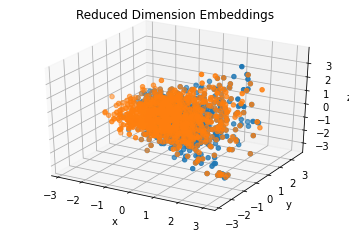

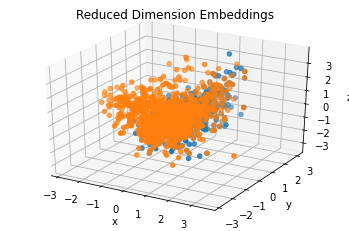

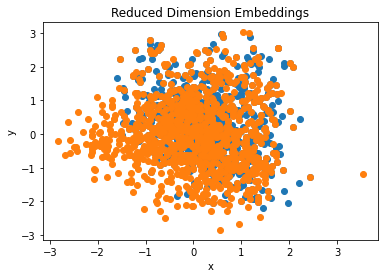

In [59]:
# Plot first axes
# Parameters
num = 2       # Which feature set to plot (0: Big PCA, 1: Isomap, 2: Small PCA)
scale = 1     # How much to scale the points by
x_axis = 1    # Which feature to plot on x axis
y_axis = 2    # Which feature to plot on y axis
z_axis = 3    # Which feature to plot on z axis

# Mask for labels
indices = np.flatnonzero(labels)

# Plot in 3d the first three dimensions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scale * transformed_features[num][indices][:,x_axis:x_axis+1], scale * transformed_features[num][indices][:,y_axis:y_axis+1], scale * transformed_features[num][indices][:,z_axis:z_axis+1])
ax.scatter(scale * transformed_features[num][~indices][:,x_axis:x_axis+1], scale * transformed_features[num][~indices][:,y_axis:y_axis+1], scale * transformed_features[num][~indices][:,z_axis:z_axis+1])
plt.xlabel("x")
plt.ylabel("y")
ax.set_zlabel('z')
plt.title("Reduced Dimension Embeddings")
plt.show()

# Plot in 3d the first three dimensions rotated
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scale * transformed_features[num][indices][:,y_axis:y_axis+1], scale * transformed_features[num][indices][:,x_axis:x_axis+1], scale * transformed_features[num][indices][:,z_axis:z_axis+1])
ax.scatter(scale * transformed_features[num][~indices][:,y_axis:y_axis+1], scale * transformed_features[num][~indices][:,x_axis:x_axis+1], scale * transformed_features[num][~indices][:,z_axis:z_axis+1])
plt.xlabel("x")
plt.ylabel("y")
ax.set_zlabel('z')
plt.title("Reduced Dimension Embeddings")
plt.show()

# Plot in 2d the first two dimensions
plt.scatter(transformed_features[num][indices][:,y_axis:y_axis+1], transformed_features[num][indices][:,x_axis:x_axis+1])
plt.scatter(transformed_features[num][~indices][:,y_axis:y_axis+1], transformed_features[num][~indices][:,x_axis:x_axis+1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reduced Dimension Embeddings")
plt.show()

#Model
We now train a 2-fully-connected-layer neural-network on the embedded data in order to classify Amazon reviews

In [72]:
# Hyperparameters
data_num = 2        # Which set of embeddings to use
scale = 1           # Scale the data

batch_size = 128    # Batch Size
hidden_dim = 32     # Dimensions of hidden layer
lr_rate = 0.0001    # Learning Rate
n_iters = 60000     # Number of iterations to run

version = 14.8      # Model Version
verbosity = 2000    # Number of iterations to print on

model_name = "Fake News"
model_type = "Logistic Regression"

In [67]:
# Keep track of these for plotting
iter = 0
losses = []
accuracies = []

In [68]:
# Data loading
# Split data into test and train

# Reduced Dimension Data
train_features, test_features, train_labels, test_labels = train_test_split(transformed_features[data_num], labels)
# Null Hypothesis Data
# train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

# Create train loader
train_data = []
for feature, label in zip(scale * train_features, train_labels):
  train_data.append([feature, label])
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Create test loader
test_data = []
for feature, label in zip(test_features, test_labels):
  test_data.append([feature, label])
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [69]:
# Define Model
# Outer dimensions of model
input_dim = transformed_features[data_num].shape[1]
# Null Hypothesis Dimensions
# input_dim = 768

output_dim = 2

# Modified Logisitic Regression
class SimpleRegression(torch.nn.Module):
    # Constructor
    def __init__(self, input_dim, output_dim):
        super(SimpleRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
        self.best_accuracy = -1
    
    # forward pass
    def forward(self, x):
        outputs = self.linear2(self.relu(self.linear(x)))
        return outputs

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    # Loads specific model
    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    # Loads most recent model
    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# Training configurations
epochs = n_iters / (len(train_features) / batch_size)
model = SimpleRegression(input_dim, output_dim)

# Optimization configurations
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

In [73]:
# Training
# Configurations
model_path = '/content/drive/My Drive/Colab Notebooks/model/' + str(version) + '/'

# Load most recent model
if os.path.exists(model_path):
  model.load_state_dict(torch.load(model_path + 'model.pt'))

# Train
for epoch in range(int(epochs)):
    for i, (x, y) in enumerate(train_loader):
        x = torch.tensor(x, dtype=torch.float64)
        y = torch.tensor(y)
        optimizer.zero_grad()
        outputs = model(x.float())
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # Load and print training data
        iter+=1
        if iter % verbosity == 0:
            # calculate Accuracy
            correct = 0
            total = 0
            for x, y in test_loader:
                x = torch.tensor(x.view(-1, input_dim))
                outputs = model(x.float())
                _, predicted = torch.max(outputs.data, 1)
                total+= y.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == y).sum()
            accuracy = 100 * correct/total
            accuracies.append(accuracy)
            losses.append(loss.item())
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
            
if not os.path.exists(model_path):
    os.makedirs(model_path)
torch.save(model.state_dict(), model_path + 'model.pt')

Iteration: 62000. Loss: 0.12252963334321976. Accuracy: 91.19999694824219.
Iteration: 64000. Loss: 0.12224634736776352. Accuracy: 91.4000015258789.
Iteration: 66000. Loss: 0.0773589015007019. Accuracy: 91.4000015258789.
Iteration: 68000. Loss: 0.0963532105088234. Accuracy: 91.4000015258789.
Iteration: 70000. Loss: 0.05885911360383034. Accuracy: 91.4000015258789.
Iteration: 72000. Loss: 0.1239931657910347. Accuracy: 91.5999984741211.
Iteration: 74000. Loss: 0.07881109416484833. Accuracy: 91.80000305175781.
Iteration: 76000. Loss: 0.0696115717291832. Accuracy: 91.19999694824219.
Iteration: 78000. Loss: 0.049965936690568924. Accuracy: 91.19999694824219.
Iteration: 80000. Loss: 0.0879720002412796. Accuracy: 91.19999694824219.
Iteration: 82000. Loss: 0.07706790417432785. Accuracy: 91.80000305175781.
Iteration: 84000. Loss: 0.06985916942358017. Accuracy: 91.5999984741211.
Iteration: 86000. Loss: 0.11177361011505127. Accuracy: 91.5999984741211.
Iteration: 88000. Loss: 0.07200966030359268. Accu

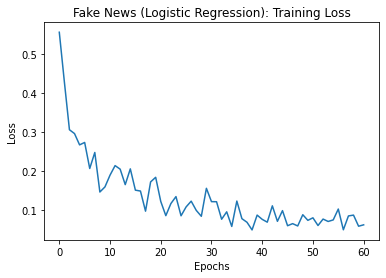

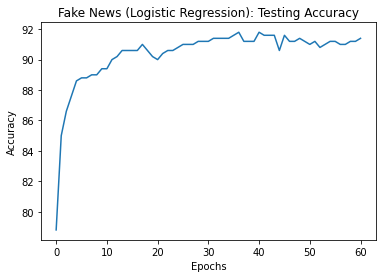

In [74]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(model_name + " (" + model_type + "): Training Loss")
plt.show()
plt.plot(accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title(model_name + " (" + model_type + "): Testing Accuracy")
plt.show()